# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендации снижайте 1 балл.

**Если решение верное, но не удовлетворяет вашим эстетическим предпочтениям, за это баллы снижать не нужно.**

# Первая часть. Исследование

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.pipeline import Pipeline

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [2]:
data_train = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/train.csv')
data_test = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/test.csv')
data_subm = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/submission.csv')

In [3]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [4]:
print('Информация о тренировочных данных:')
print(data_train.info())
print("\n\n", "-"*40, '\n\n')
print('Количество пустых значений для каждого параметра:')
print((data_train.isna() | data_train.isnull()).sum())

Информация о тренировочных данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      52

Выведем часть набора данных

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

In [5]:
# проверим наличие пустых строк в наборе данных

(data_train == r' ').sum(), (data_test == ' ').sum()

(ClientPeriod                0
 MonthlySpending             0
 TotalSpent                  9
 Sex                         0
 IsSeniorCitizen             0
 HasPartner                  0
 HasChild                    0
 HasPhoneService             0
 HasMultiplePhoneNumbers     0
 HasInternetService          0
 HasOnlineSecurityService    0
 HasOnlineBackup             0
 HasDeviceProtection         0
 HasTechSupportAccess        0
 HasOnlineTV                 0
 HasMovieSubscription        0
 HasContractPhone            0
 IsBillingPaperless          0
 PaymentMethod               0
 Churn                       0
 dtype: int64,
 ClientPeriod                0
 MonthlySpending             0
 TotalSpent                  2
 Sex                         0
 IsSeniorCitizen             0
 HasPartner                  0
 HasChild                    0
 HasPhoneService             0
 HasMultiplePhoneNumbers     0
 HasInternetService          0
 HasOnlineSecurityService    0
 HasOnlineBackup        

In [6]:
# Видно, что признак TotalSpent содержит 11 пустых строк. 
# Заменим их на nan

data_train.replace(r'^\s*$', np.nan, regex=True, inplace=True)
data_test.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [7]:
# Посмотрим на данные строки

data_train.sort_values("TotalSpent").tail(9)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,NaN,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,NaN,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,NaN,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,NaN,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,NaN,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [8]:
# Видно, что данные клиенты только присоединились к компании, заменим nan на 0.

data_train["TotalSpent"] = data_train.TotalSpent.fillna(0).astype(float)
data_test["TotalSpent"] = data_test.TotalSpent.fillna(0).astype(float)

In [9]:
#Проверим, что больше нет пустых строк

(data_train.TotalSpent == r' ').sum(), (data_test.TotalSpent == ' ').sum()

(0, 0)

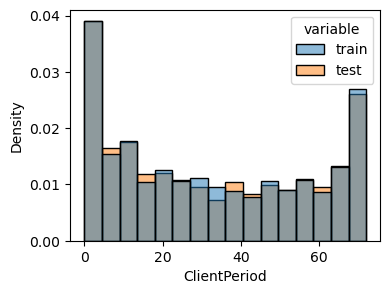

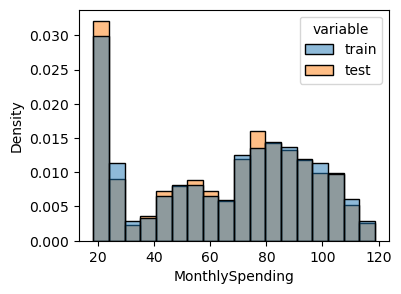

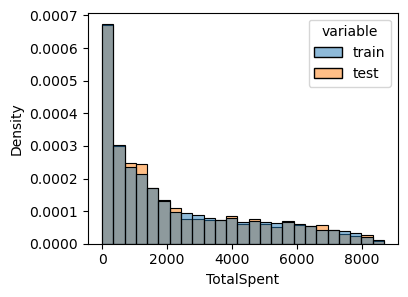

In [10]:
#Посмотрим распределение по обучающей и тестовой выборке для числовых данных. 
# Для этого, необходимо объединить на одном графике данные

for c in num_cols:
    fig = plt.figure(figsize=(4,3))
    tmp = pd.DataFrame()
    tmp['train'] = data_train[c]
    tmp['test'] = data_test[c]
    tmp = tmp.melt().dropna()
    ax = sns.histplot(data=tmp, x='value', hue='variable', stat='density', common_norm=False)
    fig.patch.set_facecolor('xkcd:white')
    ax.set(xlabel=c)
    plt.show()

Видно, что числовые данные распределены равномерно на обоих выборках

### Перейдем к анализу категориальных данных

In [11]:
# Посмотрим количесво уникальных значений для каждого признака

out = list()
for column in cat_cols:
    out.append([column, data_train[column].nunique(), dict(data_train[column].value_counts())])
pd.DataFrame(out, columns=['column', 'num_uniq', 'count_uniq'])

,column,num_uniq,count_uniq
0,Sex,2,"{'Male': 2655, 'Female': 2627}"
1,IsSeniorCitizen,2,"{0: 4440, 1: 842}"
2,HasPartner,2,"{'No': 2705, 'Yes': 2577}"
3,HasChild,2,"{'No': 3676, 'Yes': 1606}"
4,HasPhoneService,2,"{'Yes': 4761, 'No': 521}"
5,HasMultiplePhoneNumbers,3,"{'No': 2511, 'Yes': 2250, 'No phone service': ..."
6,HasInternetService,3,"{'Fiber optic': 2341, 'DSL': 1800, 'No': 1141}"
7,HasOnlineSecurityService,3,"{'No': 2612, 'Yes': 1529, 'No internet service..."
8,HasOnlineBackup,3,"{'No': 2332, 'Yes': 1809, 'No internet service..."
9,HasDeviceProtection,3,"{'No': 2317, 'Yes': 1824, 'No internet service..."


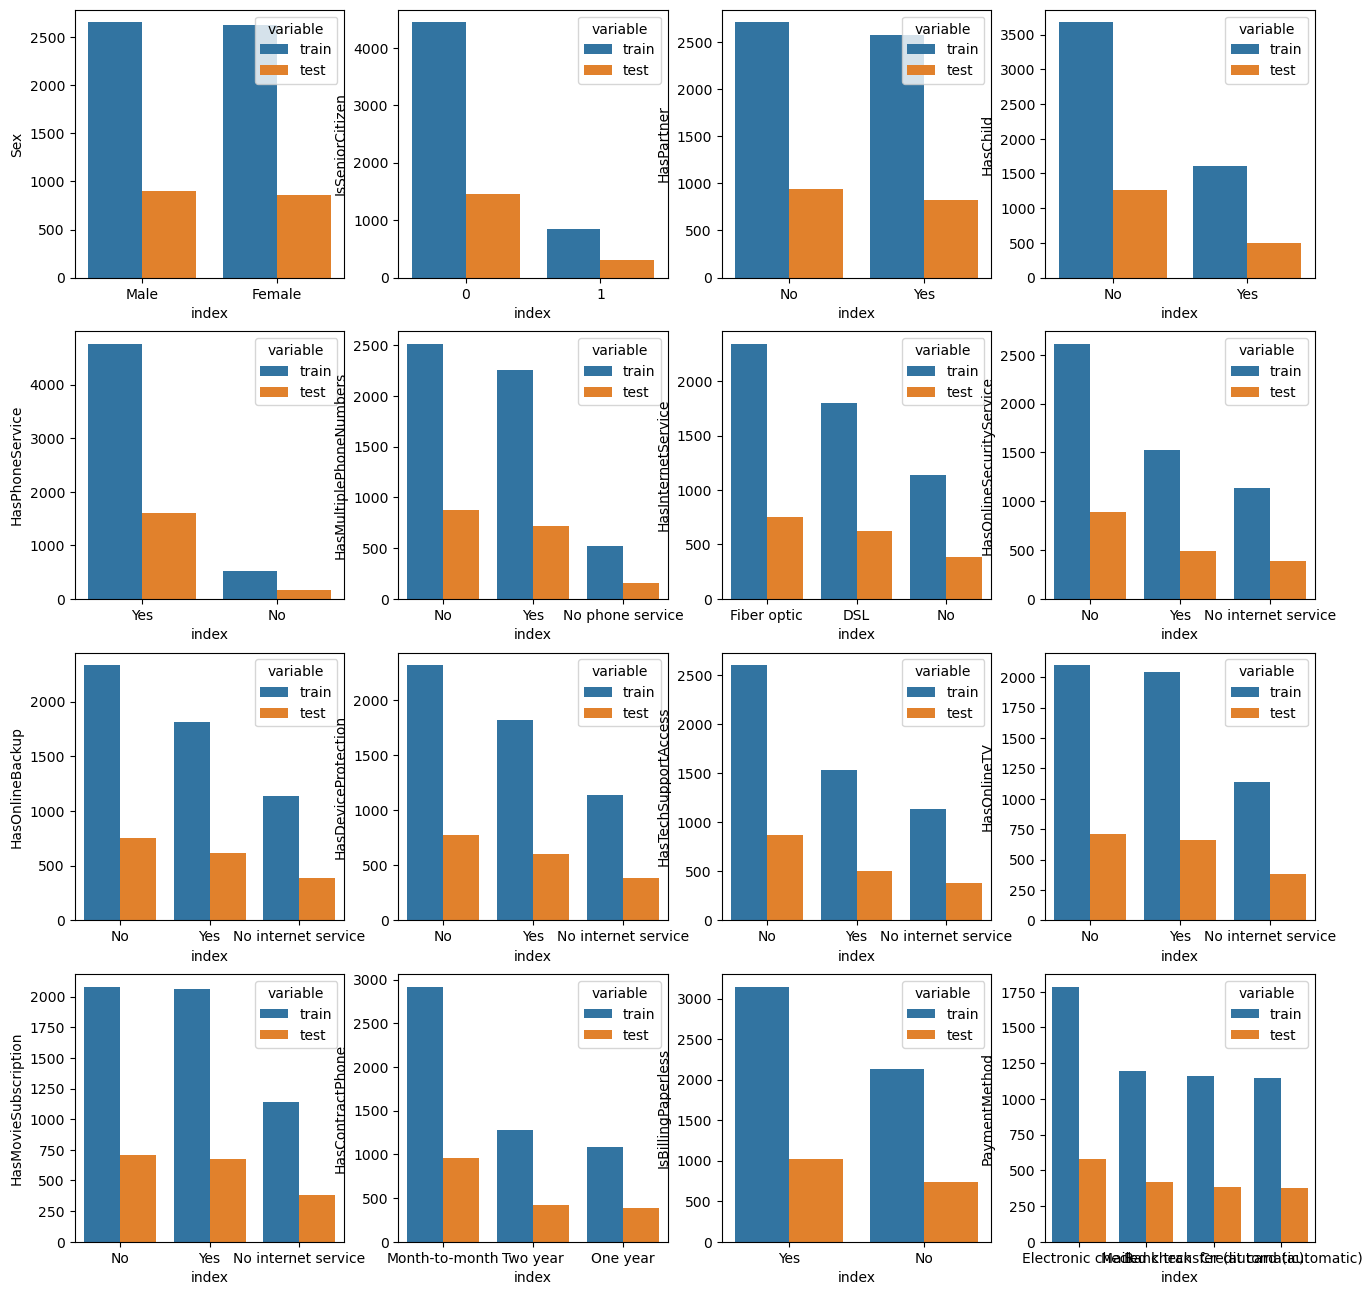

In [12]:
# посмотрим распределение данных по признакам:
fig, ax = plt.subplots(4, 4, figsize=(16,16))
ax = ax.ravel()

for i, column in enumerate(cat_cols):        
    tmp = pd.DataFrame()
    tmp['train'] = data_train[column].value_counts()
    tmp['test'] = data_test[column].value_counts()
    tmp = tmp.reset_index(drop=False)
    tmp = tmp.melt(id_vars=['index']).dropna()
    tmp['index'] = tmp['index'].astype('str')
#     print(tmp, '\n')
    sns.barplot(ax=ax[i], data=tmp, x='index', y='value', hue='variable')
    ax[i].set(ylabel=column)
    fig.patch.set_facecolor('xkcd:white')

fig.show()

<AxesSubplot:>

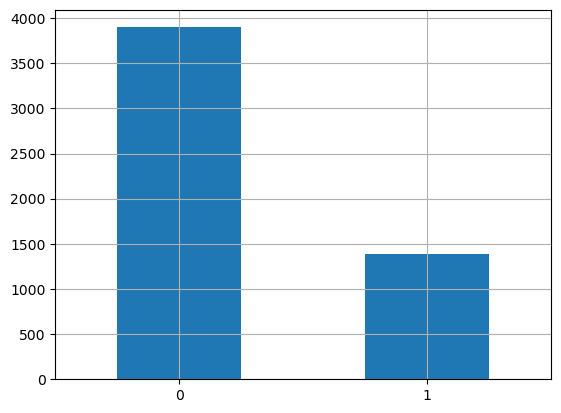

In [13]:
# для выходного признака:
data_train[target_col].value_counts().plot.bar(rot=0, grid=True)

Видно, что, в целом, данные между тестовой и обучающей выборками распределены одинаково. Наиболее неравномерные признаки для обоих выборок: 
* IsSeniorCitizen
* HasPhoneService
* Churn - целевой признак
<br><br><br>
Попробуем построить корреляционную диаграмму всех признаков. Для этого, выполним labelEncoding

In [14]:
le = preprocessing.LabelEncoder()
data_train_corr = data_train.copy()
for col in cat_cols:
    data_train_corr[col] = le.fit_transform(data_train_corr[col])

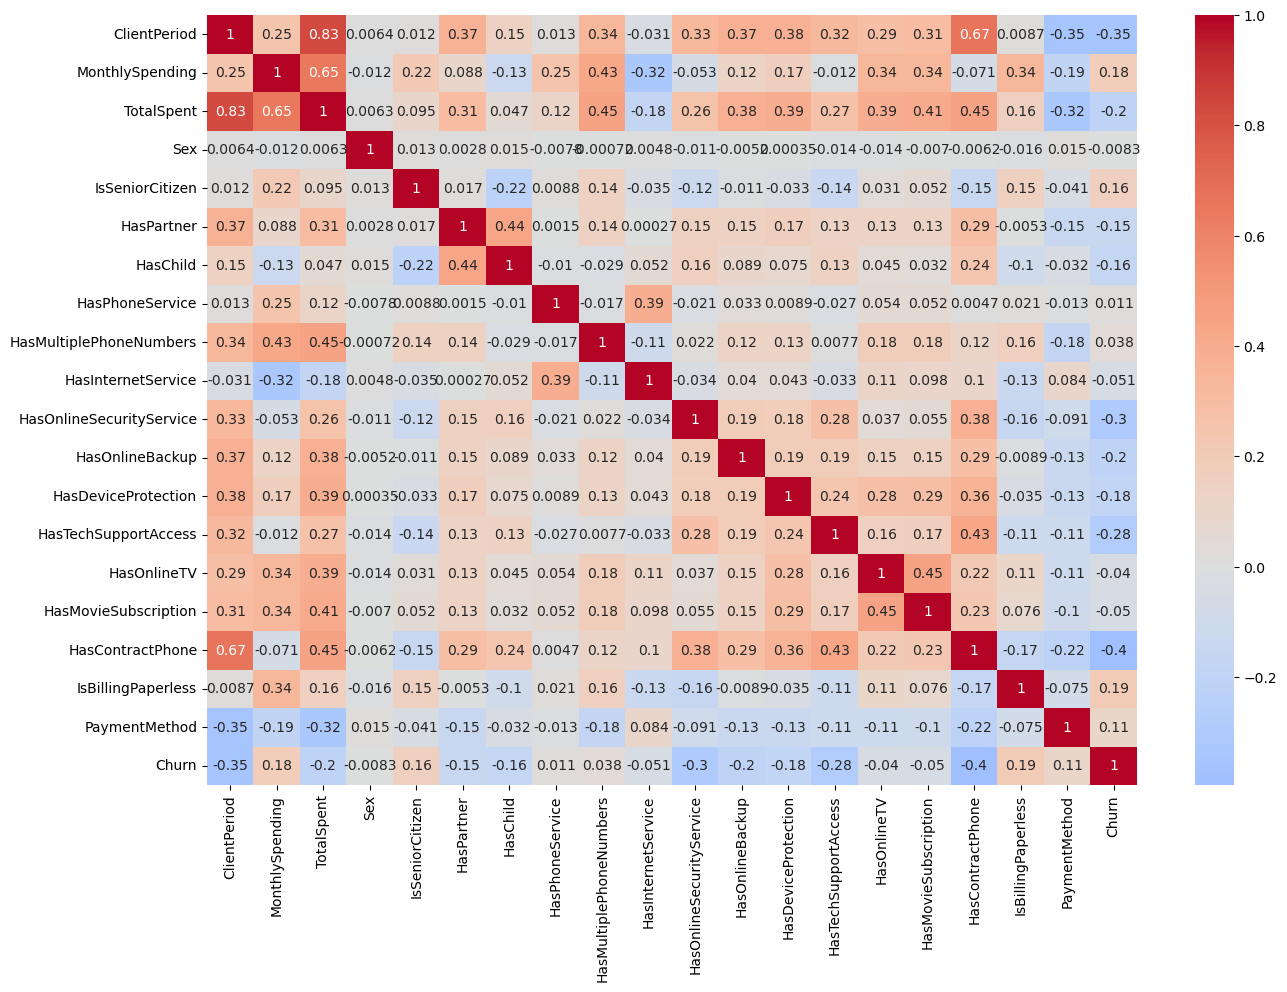

In [15]:
sns.heatmap(data=data_train_corr.corr(),
            annot=True,
            cmap="coolwarm",
            center=0,
            ax=plt.subplots(figsize=(15,10))[1])

del data_train_corr # delete this df

Видно, что с целевым признаком, ни один из обучающих признаков, коррелируют не сильно. <br>
### Для дальнейшей работы, проведем One-hot кодирование

In [16]:
data_train_dumm = pd.get_dummies(data=data_train, columns=cat_cols)
# data_train_dumm.info() # проверить

# выделим оригинальные данные
x_train_orig = data_train.iloc[:, :-1].copy()
y_train_orig = data_train.iloc[:, -1].copy()

В результате one-hot кодирования, размер dataset уменьшился в 2 раза. Далее, необходимо выделить целевую составляющую из dataset, выполнить one-hot кодирование тестовых данных и провести нормирование всех данных.

In [17]:
# выделение целевого признака
y_train_norm = data_train_dumm[target_col].copy()
x_train_dumm = data_train_dumm.drop(columns=target_col)
#x_train.info() # проверить

# one-hot кодирование
x_test_dumm = pd.get_dummies(data=data_test, columns=cat_cols)
# x_test.info() # проверить

# нормировка
scaler = StandardScaler()
x_train_norm = x_train_dumm.copy()
x_test_norm = x_test_dumm.copy()
x_train_norm[num_cols] = scaler.fit_transform(x_train_dumm[num_cols])
x_test_norm[num_cols] = scaler.transform(x_test_dumm[num_cols])

## Применение линейных моделей (3 балла)

1) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [18]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, chi2

### Создадим Pipeline

In [19]:
# для числовых данных - StandardScaler
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)
# для категориальных данных - OneHotEncoder
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)


clf = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", LogisticRegression(solver="saga", 
                                             max_iter=1000, 
                                             random_state=42))]
)

In [20]:
# %%time
param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
}

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring="roc_auc",
    n_jobs=-1,
    cv=5,
    verbose=1, 
    refit=True,
)

search_CV = grid_search.fit(x_train_orig, y_train_orig)

print(f"best score: {search_CV.best_score_}")
print(f"best params: {search_CV.best_params_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
best score: 0.8451222694111646
best params: {'classifier__C': 100, 'classifier__penalty': 'l1'}


В результате, лучший результат получился при резуляризации "l1"
и при С = 100 <br>
ROC_AUC = 0.845

## Применение градиентного бустинга (2 балла)

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

In [21]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train_orig, y_train_orig, train_size=0.85, random_state=420)
x_train

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
219,1,45.30,45.30,Female,0,No,No,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Mailed check
2012,1,20.35,20.35,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check
1288,5,20.45,106.90,Male,0,No,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check
5178,6,49.15,295.65,Male,0,Yes,Yes,Yes,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check
121,3,41.35,107.25,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,Month-to-month,No,Mailed check
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4895,69,106.50,7348.80,Male,0,No,No,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic)
4671,15,56.15,931.90,Female,0,No,No,Yes,No,DSL,No,No,No,No,Yes,No,One year,No,Mailed check
4486,4,56.75,245.15,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check
5192,1,69.65,69.65,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check


In [22]:
%%time
import catboost

model = catboost.CatBoostClassifier(iterations=200, 
                                    eval_metric='AUC:hints=skip_train~false',
                                    loss_function='CrossEntropy',
                                    learning_rate = 0.01,
                                    cat_features=cat_cols,
                                    silent = True,
                                    random_seed=42,)
grid = {
    "depth": [3, 4, 6],
    "l2_leaf_reg": [0.001, 0.01, 0.1, 1, 10],
}


grid_search_result = model.grid_search(grid,
                                       X=x_train,
                                       y=y_train,
                                       cv=5, 
                                       refit=True)



bestTest = 0.8414867818
bestIteration = 192

0:	loss: 0.8414868	best: 0.8414868 (0)	total: 1.57s	remaining: 21.9s

bestTest = 0.8412772073
bestIteration = 194

1:	loss: 0.8412772	best: 0.8414868 (0)	total: 3.03s	remaining: 19.7s

bestTest = 0.8422083171
bestIteration = 172

2:	loss: 0.8422083	best: 0.8422083 (2)	total: 4.42s	remaining: 17.7s

bestTest = 0.8441453849
bestIteration = 144

3:	loss: 0.8441454	best: 0.8441454 (3)	total: 5.81s	remaining: 16s

bestTest = 0.8432651717
bestIteration = 133

4:	loss: 0.8432652	best: 0.8441454 (3)	total: 7.01s	remaining: 14s

bestTest = 0.84217239
bestIteration = 115

5:	loss: 0.8421724	best: 0.8441454 (3)	total: 8.64s	remaining: 13s

bestTest = 0.8430406275
bestIteration = 139

6:	loss: 0.8430406	best: 0.8441454 (3)	total: 10.3s	remaining: 11.8s

bestTest = 0.8435316308
bestIteration = 183

7:	loss: 0.8435316	best: 0.8441454 (3)	total: 11.9s	remaining: 10.4s

bestTest = 0.8441573606
bestIteration = 106

8:	loss: 0.8441574	best: 0.8441574 (8)	tot

In [23]:
grid_search_result['params']

{'depth': 4, 'l2_leaf_reg': 1}

In [24]:
model = catboost.CatBoostClassifier(iterations=1000, 
                                    eval_metric='AUC:hints=skip_train~false',
                                    loss_function='CrossEntropy',
                                    depth = 4,
                                    cat_features = cat_cols,
                                    l2_leaf_reg = 1,
                                    learning_rate = 0.01,
                                    verbose = 200,
                                    random_seed=42)

model.fit(x_train, y_train, 
             eval_set=[(x_train, y_train), 
                        (x_valid, y_valid)])

y_valid_predicted = model.predict_proba(x_valid)[:, 1]
roc_auc_score(y_valid, y_valid_predicted)

0:	learn: 0.7484503	test: 0.7484503	test1: 0.7424701	best: 0.7424701 (0)	total: 12.9ms	remaining: 12.9s
200:	learn: 0.8507648	test: 0.8502991	test1: 0.8468426	best: 0.8469435 (194)	total: 1.93s	remaining: 7.65s
400:	learn: 0.8574818	test: 0.8559754	test1: 0.8506076	best: 0.8507085 (384)	total: 3.83s	remaining: 5.72s
600:	learn: 0.8616007	test: 0.8585990	test1: 0.8515488	best: 0.8515741 (598)	total: 5.85s	remaining: 3.88s
800:	learn: 0.8654127	test: 0.8606193	test1: 0.8515278	best: 0.8518976 (660)	total: 8.11s	remaining: 2.01s
999:	learn: 0.8696085	test: 0.8633608	test1: 0.8520699	best: 0.8522758 (917)	total: 10.3s	remaining: 0us

bestTest = 0.8522757832
bestIteration = 917

Shrink model to first 918 iterations.


0.8522757832459326

### XGBoost

In [25]:
from xgboost import XGBClassifier

xgbClass = XGBClassifier(random_state=420, 
                         n_estimators=1000, 
                         max_depth=6,
                         learning_rate=0.01,
                         enable_categorical=True,
                         tree_method="hist",)

x_train[cat_cols] = x_train[cat_cols].astype("category")
x_valid[cat_cols] = x_valid[cat_cols].astype("category")

xgbClass.fit(x_train, y_train, 
             eval_set=[(x_train, y_train), 
                        (x_valid, y_valid)],
             verbose = 200)

y_valid_predicted = xgbClass.predict_proba(x_valid)[:, 1]
roc_auc_score(y_valid, y_valid_predicted)


[0]	validation_0-logloss:0.68837	validation_1-logloss:0.68871
[200]	validation_0-logloss:0.38041	validation_1-logloss:0.42799
[400]	validation_0-logloss:0.33298	validation_1-logloss:0.41581
[600]	validation_0-logloss:0.31487	validation_1-logloss:0.41763
[800]	validation_0-logloss:0.30134	validation_1-logloss:0.41967
[999]	validation_0-logloss:0.28775	validation_1-logloss:0.42062


0.8404304491058222

### Стэкинг

In [26]:
%%time

logregClass = LogisticRegression(solver="saga", 
                                 max_iter=1000,
                                 C = 100,
                                 penalty = 'l1',
                                 random_state=42)

randForest = RandomForestClassifier(random_state=1)

CatClass = catboost.CatBoostClassifier(iterations=5000,
                                       eval_metric='AUC:hints=skip_train~false',
                                       loss_function='CrossEntropy',
                                       depth = 4,
                                       l2_leaf_reg = 1,
                                       learning_rate = 0.01,
                                       verbose = 200,
                                       random_seed=42)

estimators=[
        ("logreg", logregClass),
        ("xgboost", xgbClass),
        ("rand_forest", randForest),
]

stacking = StackingClassifier(
    estimators = estimators,
    final_estimator=CatClass,
    n_jobs=-1)

stacking.fit(x_train_norm, y_train_norm)

0:	learn: 0.7865840	total: 3.08ms	remaining: 15.4s
200:	learn: 0.8488249	total: 562ms	remaining: 13.4s
400:	learn: 0.8525769	total: 1.14s	remaining: 13s
600:	learn: 0.8564979	total: 1.72s	remaining: 12.6s
800:	learn: 0.8600609	total: 2.31s	remaining: 12.1s
1000:	learn: 0.8645534	total: 2.87s	remaining: 11.5s
1200:	learn: 0.8689150	total: 3.45s	remaining: 10.9s
1400:	learn: 0.8730504	total: 4.02s	remaining: 10.3s
1600:	learn: 0.8770433	total: 4.6s	remaining: 9.76s
1800:	learn: 0.8803650	total: 5.11s	remaining: 9.08s
2000:	learn: 0.8834393	total: 5.65s	remaining: 8.47s
2200:	learn: 0.8862635	total: 6.26s	remaining: 7.96s
2400:	learn: 0.8890408	total: 6.86s	remaining: 7.42s
2600:	learn: 0.8914529	total: 7.42s	remaining: 6.84s
2800:	learn: 0.8941312	total: 7.94s	remaining: 6.23s
3000:	learn: 0.8967707	total: 8.45s	remaining: 5.63s
3200:	learn: 0.8994125	total: 9.02s	remaining: 5.07s
3400:	learn: 0.9020050	total: 9.61s	remaining: 4.52s
3600:	learn: 0.9042722	total: 10.1s	remaining: 3.93s
38

StackingClassifier(estimators=[('logreg',
                                LogisticRegression(C=100, max_iter=1000,
                                                   penalty='l1',
                                                   random_state=42,
                                                   solver='saga')),
                               ('xgboost',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              callbacks=None,
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1,
                                              early_stopping_rounds=None,
                                              enable_categorical=True,
                                              eval_metric=None, gamma=0,
                                              gpu_id=-1,
                         

Среди всех моделей, наилучшее качество на обучающей выборке получилось при стэкинге моделей. 
<br>
ROC_AUC = 0.919
<br>
на тестовой выборке, результат 0.84

In [27]:
best_model = stacking
submission = data_subm
submission["Churn"] = best_model.predict_proba(x_test_norm)[:, 1]
submission.to_csv("submission.csv", index=False)